# Solve package versions

After each cell, you will be asked to restart the notebook. That's normal, just click "Restart session" and move to the next cell.

This process only has to be done once.

In [ ]:
# ! pip uninstall PIL -y
# ! pip install PILLOW==9.5.0

In [ ]:
# ! pip uninstall tensorflow -y
# ! pip install tensorflow==2.13.0

In [ ]:
# ! pip install git+https://github.com/MihaMarkic/tflearn.git@fix/is_sequence_missing

# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

In [ ]:
import cv2
import imageio as iio
import urllib.request

# load tensorflow packages
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
import tensorflow as tf
from tflearn.layers.core import input_data, fully_connected, dropout

Instructions for updating:
non-resource variables are not supported in the long term


# Download GalaxyZoo training data

In [ ]:
url = "https://jaredcsiegel.github.io/files/for_astr207/training_solutions_rev1_short.csv"
filename, headers = urllib.request.urlretrieve(url, filename="training_solutions_rev1_short.csv")

In [ ]:
url = "https://jaredcsiegel.github.io/files/for_astr207/images_training_rev1_short.zip"
filename, headers = urllib.request.urlretrieve(url, filename="images_training_rev1_short.zip")

In [ ]:
# only run once
# ! unzip images_training_rev1_short.zip

# Load training data and galaxy images


In [ ]:
training_classifications = pd.read_csv('training_solutions_rev1_short.csv')

In [ ]:
# expected runtime: 30 seconds

def norm(x):
    return (x-x.max()) / (x.max() - x.min())

images_f = []
images   = []
classes  = []

# loop over galaxy IDs
for i,j in tqdm(enumerate(training_classifications['GalaxyID'].values)):

    # load image
    img_f = iio.v3.imread(f"images_training_rev1_short/{j}.jpg")

    # select green band and downsample to 80x80 (for speed)
    img = cv2.resize(img_f[:,:,0], (80, 80)) #

    # select Spiral + Elliptical classification scores
    c1 = training_classifications['Class1.1'].values[i]
    c2 = training_classifications['Class1.2'].values[i]

    # store it
    images.append(img)
    images_f.append(img_f)

    classes.append([
        c1,
        c2
        ])

images   = np.array(images)
classes  = np.array(classes)

7000it [00:33, 207.14it/s]


# Set aside 5% of the training data for testing

In [ ]:
# divide the dataset between testing and training
ftrain = 0.95
ntrain = int(len(images)*ftrain)

X_train = images[:ntrain]
Y_train = classes[:ntrain]
I_train = images_f[:ntrain]

X_test = images[ntrain:]
Y_test = classes[ntrain:]
I_test = images_f[ntrain:]

# image scale and learning rate
IMG_SIZE = images.shape[1]
LR = 1e-3

# reshape for compatibility with the network
X_train_ = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test_  = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Build Convolutional Neural Network

In [ ]:
# build the network (this is currently a convolutional NN)
# changing the size and depth should be straightforward by modifying the lines below

tf.compat.v1.reset_default_graph()
convnet = input_data(shape =[None, IMG_SIZE, IMG_SIZE, 1], name ='input')

convnet = conv_2d(convnet, 32, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation ='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation ='softmax')

convnet = regression(convnet, optimizer ='adam', learning_rate = LR,
      loss ='categorical_crossentropy', name ='targets')

model = tflearn.DNN(convnet, tensorboard_dir ='log')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Train the model

(expected runtime: 3 minutes)

In [ ]:
model.fit({'input': X_train_}, {'targets': Y_train}, n_epoch = 5,
    snapshot_step = 500, show_metric = True,
    validation_set =({'input': X_test_}, {'targets': Y_test}))

Training Step: 519  | total loss: 0.39160 | time: 54.937s
| Adam | epoch: 005 | loss: 0.39160 - acc: 0.9279 -- iter: 6592/6650
Training Step: 520  | total loss: 0.38963 | time: 56.392s
| Adam | epoch: 005 | loss: 0.38963 - acc: 0.9273 | val_loss: 0.43819 - val_acc: 0.8857 -- iter: 6650/6650
--


# Evaluate the model on the training and test data

(expected runtime: 30 seconds)

In [ ]:
model_output_test  = np.array([ model.predict([X_test_[i]])[0]  for i in range(len(X_test_))  ])
model_output_train = np.array([ model.predict([X_train_[i]])[0] for i in range(len(X_train_)) ])

# Calculate model accuracy

In [ ]:
for name, mY, Y in zip(['Test Set:','Training Set:'],[model_output_test, model_output_train],[Y_test, Y_train]):

  is_spiral   = Y[:,1]>0.5
  is_spiral_m = (mY[:,1] > 0.5)
  f_spiral_correct = len(is_spiral_m[is_spiral_m & is_spiral]) / len(is_spiral[is_spiral])

  is_elliptical   = Y[:,0]>0.5
  is_elliptical_m = (mY[:,0] > 0.5)
  f_elliptical_correct = len(is_elliptical_m[is_elliptical_m & is_elliptical]) / len(is_elliptical[is_elliptical])

  print(name)
  print(f'Spiral classification accuracy: {f_spiral_correct:.3}')
  print(f'Elliptical classification accuracy: {f_elliptical_correct:.3}\n')

Test Set:
Spiral classification accuracy: 0.884
Elliptical classification accuracy: 0.888

Training Set:
Spiral classification accuracy: 0.925
Elliptical classification accuracy: 0.926



# Visually inspect classifications

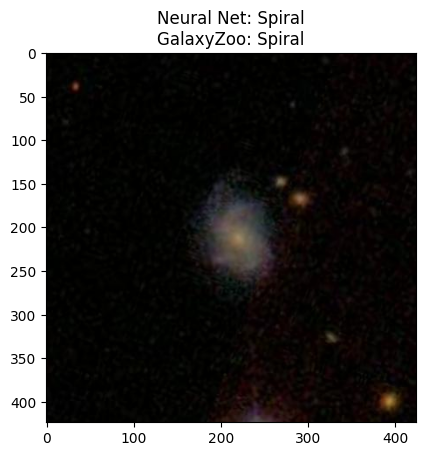

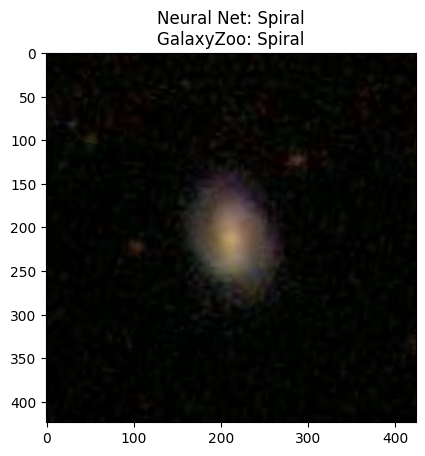

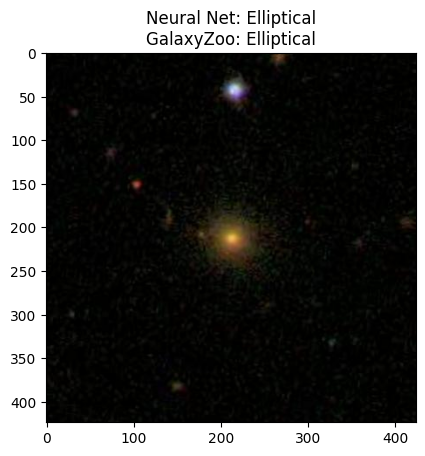

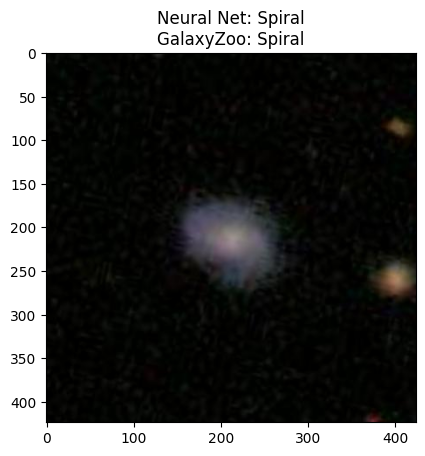

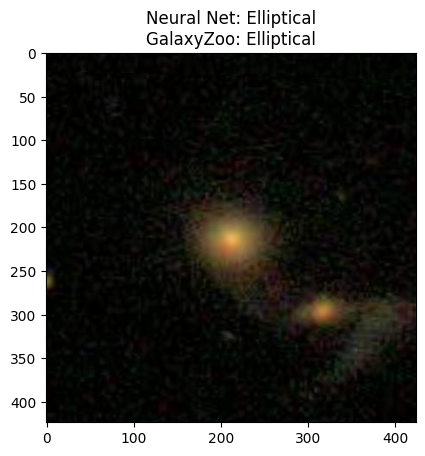

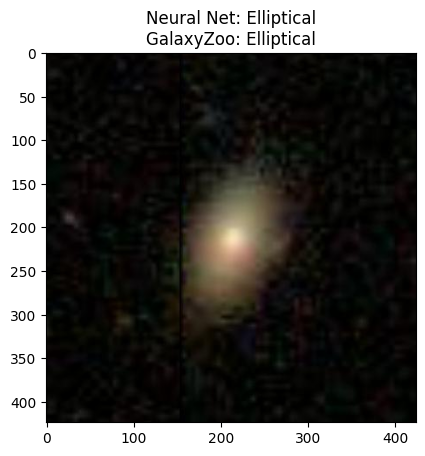

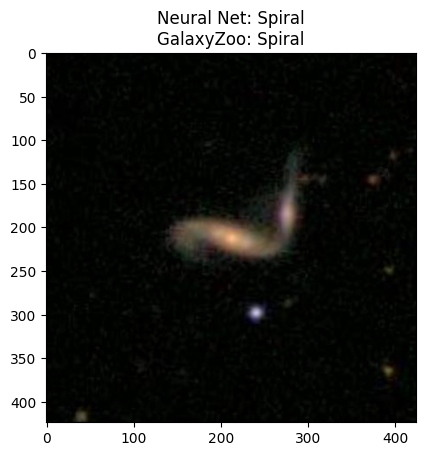

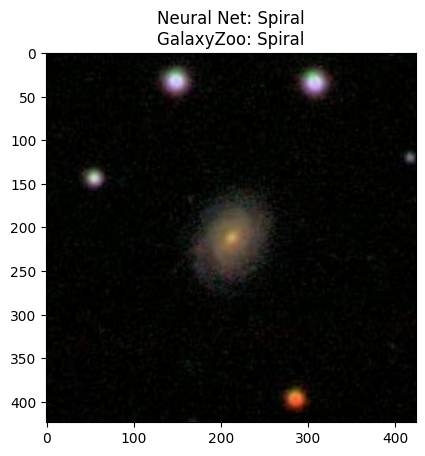

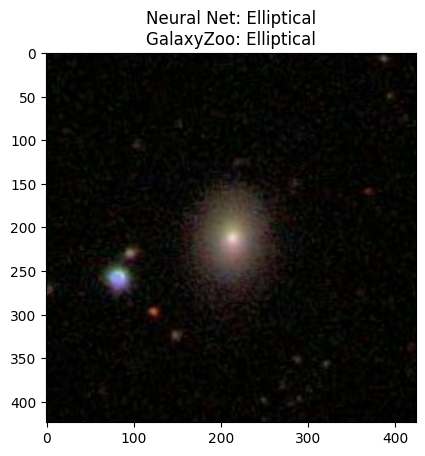

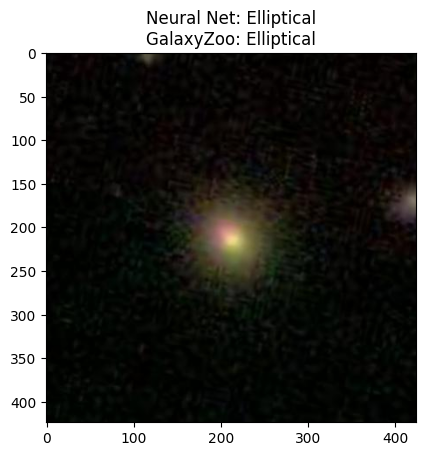

In [ ]:
# predicted classification for N test galaxies
N = 10

for i in range(len(X_test_[:N])):
    model_out = model.predict([X_test_[i]])

    if model_out[0][0] < 0.5:
        title = 'Neural Net: Spiral\n'
    else:
        title = 'Neural Net: Elliptical\n'

    if Y_test[i][0] < 0.5:
        title += 'GalaxyZoo: Spiral'
    else:
        title += 'GalaxyZoo: Elliptical'

    plt.imshow(I_test[i])
    plt.title(title)
    plt.show()